# This notebook should predict WB_sg from up to 10 input features.

Andrew Fagerheim and Bernard Wang

In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2023-12-22 22:03:53.372547: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-22 22:03:53.410305: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()
input_features = ['grad_B','FCOR', 'HML', 'Nsquared', 'Q', 'TAU', 'HBL', 'strain', 'vort', 'div']
# 0. Depth-averaged buoyancy gradient magnitude
# 1. Coriolis parameter
# 2. Mixed layer depth
# 3. Brunt-Vaisala frequency
# 4. Surface heat flux
# 5. Surface wind stress magnitude
# 6. Boundary layer depth
# 7. Depth-averaged strain magnitude
# 8. Depth-averaged vertical vorticity
# 9. Depth-averaged horizontal divergence

output_feature = 'WB_sg'
# Depth-averaged vertical bouyancy flux

label_list = ['Arabian Sea','New Zealand', 'Agulhas Current', 'Kuroshio Extension', 'North Pacific', 'Equatorial Atlantic',
              'Gulf Stream', 'South Atlantic', 'Malvinas Current', 'South Pacific','California Current', 'Indian Ocean', ]

month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [3]:
location_index = np.zeros(846*12)
location_month_index= np.zeros(846*12)

# 846/14 = 60, 846 length of timeseries in each region, 14 months of data
for i in range(12):
    for j in range(846):
        location_index[i*846+j] = i
        location_month_index[i*846+j] = np.floor(j/60)

### 1. Load and normalize Input

In [4]:
# 1. Create xarray dataset, populate it with the numpy files but turn them into dataarrays.
X_xr = xr.Dataset()
X_xr_og = xr.Dataset()
for input_feature in input_features:
    var = np.load('data/%s.npy' % input_feature)
    var_xr = xr.DataArray(var, coords={'time': np.arange(0, len(var)),'lat': np.arange(0, 40),'lon': np.arange(0, 40)}, dims=["time", "lat", "lon"])
    X_xr_og[input_feature] = var_xr #unnormalized
    X_xr[input_feature] = (var_xr - var_xr.mean()) / var_xr.std() #normalized
X_xr = X_xr.assign_coords(location=('time', location_index))
X_xr_og = X_xr_og.assign_coords(location=('time', location_index))
# X_xr_og: not normalized.
# X_xr: normalized.

In [5]:
X_xr

<xarray.Dataset>
Dimensions:   (time: 10152, lat: 40, lon: 40)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 ... 10146 10147 10148 10149 10150 10151
  * lat       (lat) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
  * lon       (lon) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
    location  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 11.0 11.0 11.0 11.0 11.0
Data variables:
    grad_B    (time, lat, lon) float64 -0.5969 -0.5104 ... -0.3318 0.5773
    FCOR      (time, lat, lon) float64 0.3344 0.3344 0.3344 ... -0.1989 -0.1989
    HML       (time, lat, lon) float64 0.2489 0.2642 0.2574 ... 0.424 0.3288
    Nsquared  (time, lat, lon) float64 -0.2498 -0.2447 ... -0.3052 -0.2827
    Q         (time, lat, lon) float64 -0.8277 -0.816 ... -0.4634 -0.5633
    TAU       (time, lat, lon) float64 -0.5077 -0.5075 -0.5202 ... 0.6422 0.6074
    HBL       (time, lat, lon) float64 -0.305 -0.3105 -0.3083 ... -0.326 -0.2534
    strain    (time, lat, lon) float64 -0.474 -0.7203 ... -0.4636 -0.1761
    vort      (time, lat, lon) float64 -0.1777 0.08519 0.2384 ... 0.8995 0.8972
    div       (time, lat, lon) float64 0.2915 0.04385 0.309 ... 0.3343 -0.3322

In [6]:
# Determine the random part of the dataset that will be training data, and the other part will be testing data.
train_split = 0.8

time_indices = len(X_xr.time)
train_cutoff = round(train_split*time_indices)
rand_indices = np.arange(time_indices)
np.random.shuffle(rand_indices)

# THESE INDICES WILL BE USED FOR BOTH THE INPUT AND OUTPUT.
train_indices = rand_indices[:train_cutoff]
test_indices = rand_indices[train_cutoff:]

In [7]:
print('Training indices: ', train_indices, ' with length' , len(train_indices))
print('Testing indices: ', test_indices, 'with length' , len(test_indices))

Training indices:  [8929  540 6508 ... 1536 8142 9242]  with length 8122
Testing indices:  [5194 4080 7237 ...  568 2779 5157] with length 2030


In [8]:
# Train indices: random 80% of the data. Test indices: random 20% of the data.
X_train_xr = X_xr.isel(time=train_indices)
X_test_xr = X_xr.isel(time=test_indices)


### 2. Load and normalize output

In [9]:
# 1. load WB_sg numpy file from data. WB_sg: Vertical Buoyancy Flux
WB_sg = np.load('data/WB_sg.npy')
# 2. turn the data into an xarray dataarray
WB_sg_xr_og = xr.DataArray(WB_sg, coords={'time': np.arange(0, len(WB_sg)),'lat': np.arange(0, 40),'lon': np.arange(0, 40)}, dims=["time", "lat", "lon"])
WB_sg_xr = (WB_sg_xr_og - WB_sg_xr_og.mean()) / WB_sg_xr_og.std()
WB_sg_xr = WB_sg_xr.assign_coords(location=('time', location_index))
WB_sg_xr_og = WB_sg_xr_og.assign_coords(location=('time', location_index))

# training:
y_train_xr = WB_sg_xr.isel(time=train_indices)
y_train_np = y_train_xr.data

# we will save y_test_xr, and y_test_og_xr as nc files. y_test_xr is normalized, y_test_og_xr is not normalized.
y_test_xr = WB_sg_xr.isel(time=test_indices)
y_test_np = y_test_xr.data
y_test_xr_og = WB_sg_xr_og.isel(time=test_indices)

In [10]:
X_train_np = X_train_xr.to_array().transpose('time', 'lat', 'lon', 'variable').data
X_test_np  = X_test_xr.to_array().transpose('time', 'lat', 'lon', 'variable').data
lat, lon, num_inputs = X_train_np.shape[1:]

print(X_train_np.shape,y_train_np.shape,X_test_np.shape,y_test_np.shape)

(8122, 40, 40, 10) (8122, 40, 40) (2030, 40, 40, 10) (2030, 40, 40)


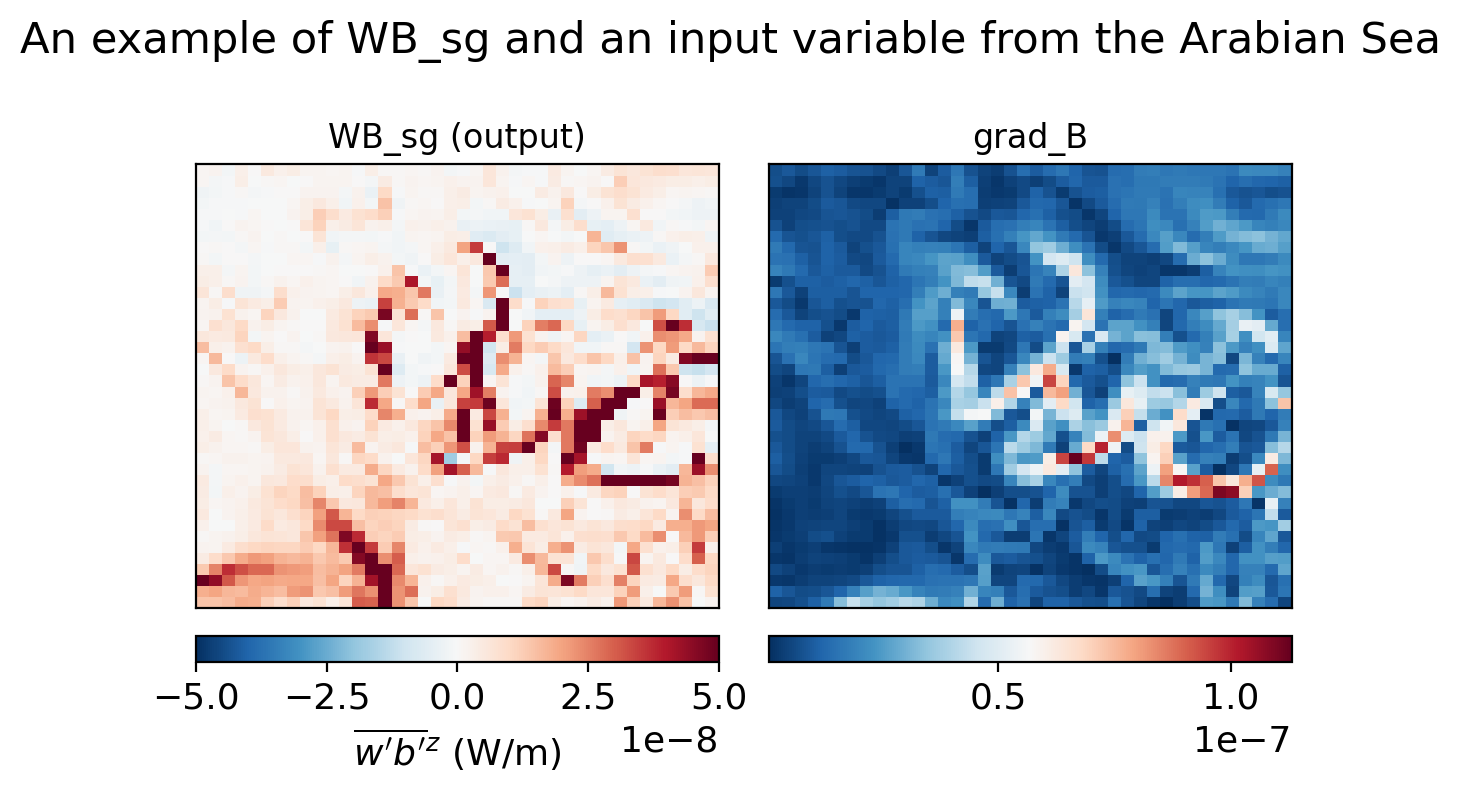

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(6,4))

ind=2
clim = 5e-8

input_var = 0
input_features[input_var]

output_map = WB_sg_xr_og[ind]
i_var_loc = 0
i_var = input_features[i_var_loc]
input_map = X_xr_og[i_var][ind]
loc_ind = int(output_map.location)

plt.subplot(1, 2, 1)
plt.pcolor(np.flip(output_map, axis=0),cmap='RdBu_r',vmin=-clim,vmax=clim)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(location='bottom',pad=0.05)
cb.set_label(r'$\overline{w^\prime b^\prime}^z$' + ' (W/m)')
plt.title('WB_sg (output)',fontsize=12)

plt.subplot(1, 2, 2)
plt.pcolor(np.flip(input_map, axis=0),cmap='RdBu_r')
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(location='bottom',pad=0.05)
plt.title(i_var,fontsize=12)
plt.suptitle('An example of WB_sg and an input variable from the ' + label_list[loc_ind])
plt.tight_layout()


## Define CNN Structure

In [13]:
n_filters  = 32  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 5
hidden_kernel_size = 3
learning_rate  = 0.001
minibatch_size = 64
num_epochs     = 100

In [14]:
print('X_train_np shape:')
print('\t',X_train_np.shape)
# (8122, 40, 40, 10)
# input wants to be (batch_size, height, width, channels) so I think this is fine.
# There should be 10 (or however many variables we want to use) input channels.
# There should be 1 output channel: the WB_sg variable.
input_shape = X_train_np.shape[1:]
print('input shape into model:')
print('\t',input_shape)

X_train_np shape:
	 (8122, 40, 40, 10)
input shape into model:
	 (40, 40, 10)


In [ ]:
# ### model using MSE as loss function

# model_mse = Sequential()

# model_mse.add(Conv2D(filters=128, kernel_size = kernel_size, input_shape = X_train_np.shape[1:],
#                     activation=activation, padding='same'))
# model_mse.add(BatchNormalization())
# model_mse.add(Conv2D(filters=64, kernel_size = hidden_kernel_size,
#                      activation = activation, padding='same'))
# model_mse.add(BatchNormalization())
# model_mse.add(Conv2D(filters=64, kernel_size = hidden_kernel_size,
#                      activation = 'linear', padding='same'))
# model_mse.add(BatchNormalization())
# model_mse.add(Conv2D(filters=1, kernel_size = hidden_kernel_size,
#                      activation = 'linear', padding='same'))

# model_mse.summary()
# model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


In [15]:
### model using MSE as loss function

model_mse = Sequential()

model_mse.add(Conv2D(filters=128, kernel_size = kernel_size, input_shape = X_train_np.shape[1:],
                    activation=activation, padding='same'))
model_mse.add(BatchNormalization())
model_mse.add(Conv2D(filters=64, kernel_size = hidden_kernel_size,
                     activation = activation, padding='same'))
model_mse.add(BatchNormalization())
model_mse.add(Conv2D(filters=32, kernel_size = hidden_kernel_size,
                     activation = 'linear', padding='same'))
model_mse.add(BatchNormalization())
model_mse.add(Conv2D(filters=32, kernel_size = hidden_kernel_size,
                     activation = 'linear', padding='same'))
model_mse.add(BatchNormalization())
# model_mse.add(Conv2D(filters=32, kernel_size = hidden_kernel_size,
#                      activation = 'linear', padding='same'))
# model_mse.add(BatchNormalization())
# model_mse.add(Conv2D(filters=32, kernel_size = hidden_kernel_size,
#                      activation = 'linear', padding='same'))
# model_mse.add(BatchNormalization())
# model_mse.add(Conv2D(filters=32, kernel_size = hidden_kernel_size,
#                      activation = 'linear', padding='same'))
# model_mse.add(BatchNormalization())


model_mse.add(Conv2D(filters=1, kernel_size = hidden_kernel_size,
                     activation = 'linear', padding='same'))

model_mse.summary()
model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 128)       32128     
                                                                 
 batch_normalization (BatchN  (None, 40, 40, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 64)        73792     
                                                                 
 batch_normalization_1 (Batc  (None, 40, 40, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 32)        18464     
                                                                 
 batch_normalization_2 (Batc  (None, 40, 40, 32)       1

## Train da model

In [95]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

###------------mse------------
history_mse = model_mse.fit(X_train_np, y_train_np, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

Epoch 1/100
102/102 [==============================] - 33s 311ms/step - loss: 0.7824 - val_loss: 0.7431
Epoch 2/100
102/102 [==============================] - 31s 307ms/step - loss: 0.5323 - val_loss: 0.6541
Epoch 3/100
102/102 [==============================] - 32s 310ms/step - loss: 0.4975 - val_loss: 0.5712
Epoch 4/100
102/102 [==============================] - 31s 305ms/step - loss: 0.4665 - val_loss: 0.5533
Epoch 5/100
102/102 [==============================] - 31s 308ms/step - loss: 0.4629 - val_loss: 0.4797
Epoch 6/100
102/102 [==============================] - 31s 307ms/step - loss: 0.4396 - val_loss: 0.4864
Epoch 7/100
102/102 [==============================] - 32s 313ms/step - loss: 0.4209 - val_loss: 0.4558
Epoch 8/100
102/102 [==============================] - 32s 311ms/step - loss: 0.4196 - val_loss: 0.4445
Epoch 9/100
102/102 [==============================] - 31s 309ms/step - loss: 0.4076 - val_loss: 0.4273
Epoch 10/100
102/102 [==============================] - 31s 308m

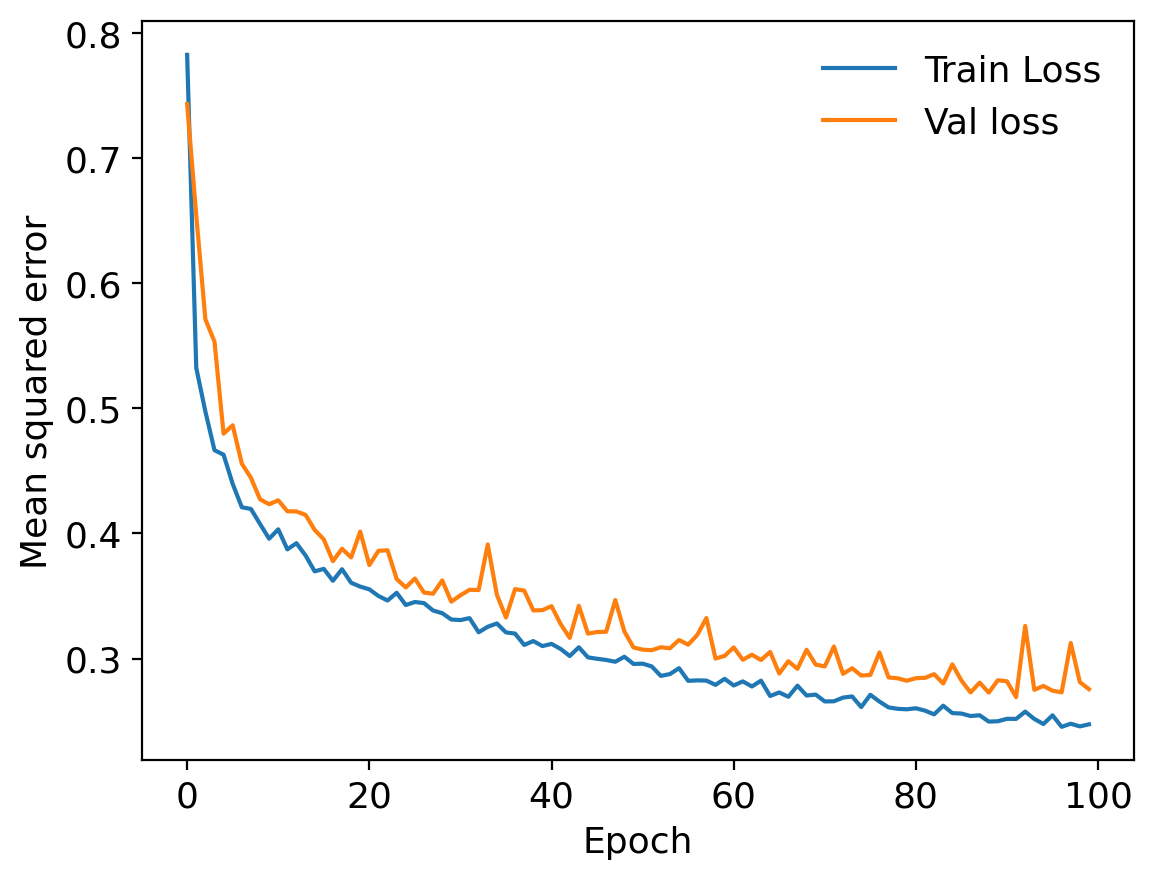

In [97]:
plot_history(history_mse)
# 5 layers

In [98]:
model_path = os.path.join(cwd,'tensorflow_models')
make_dir(model_path)

### Save your model, and your testing data files.

In [99]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_mse.save(os.path.join(model_path,'CNN_model_mse.h5'))
# we should save the testing data too right? Save y_test_xr here.
y_test_xr.to_netcdf(os.path.join(model_path,'y_test.nc'))
y_test_xr_og.to_netcdf(os.path.join(model_path,'y_test_og.nc'))
WB_sg_xr_og.to_netcdf(os.path.join(model_path,'WB_sg.nc'))

# Evaluate da Trained Model

In [100]:
# reload the saved model
model_mse = load_model(os.path.join(model_path,'CNN_model_mse.h5'))

In [114]:
y_test_mse_pre = model_mse.predict(X_test_np)
y_test_mse_pre = y_test_mse_pre.reshape(y_test_mse_pre.shape[0], 40, 40)
y_test_mse_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'lat': X_test_xr.lat.values, 
                               'lon': X_test_xr.lon.values},
                       data_vars=dict(WB_sg_normalized=(['time', 'lat', 'lon'], y_test_mse_pre)))
y_test_mse_pre = y_test_mse_pre.assign_coords(location=('time', y_test_xr.location.values))

64/64 [==============================] - 3s 41ms/step


In [121]:
# reload the actual test data, get mean and std
y_test_og_xr = xr.open_dataarray(os.path.join(model_path,'y_test_og.nc'))
y_test_xr = xr.open_dataarray(os.path.join(model_path,'y_test.nc'))

WB_sg_og_xr = xr.open_dataarray(os.path.join(model_path,'WB_sg.nc'))
mean = WB_sg_og_xr.mean()
std = WB_sg_og_xr.std()

# scale up the model
y_test_mse_pre['WB_sg_og'] = y_test_mse_pre.WB_sg_normalized * std + mean

In [141]:
# PUT THIS SHIT BACK IN LOCATION BASED AND CHRONOLOGICAL ORDER I GUESS.

In [122]:
y_test_mse_pre

<xarray.Dataset>
Dimensions:           (time: 2030, lat: 40, lon: 40)
Coordinates:
  * time              (time) int64 7356 1587 9590 7254 ... 623 9788 6644 5872
  * lat               (lat) int64 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39
  * lon               (lon) int64 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39
    location          (time) float64 8.0 1.0 11.0 8.0 7.0 ... 0.0 11.0 7.0 6.0
Data variables:
    WB_sg_normalized  (time, lat, lon) float32 0.05553 0.6923 ... -0.3825
    WB_sg_og          (time, lat, lon) float64 6.31e-09 1.318e-08 ... 1.582e-09

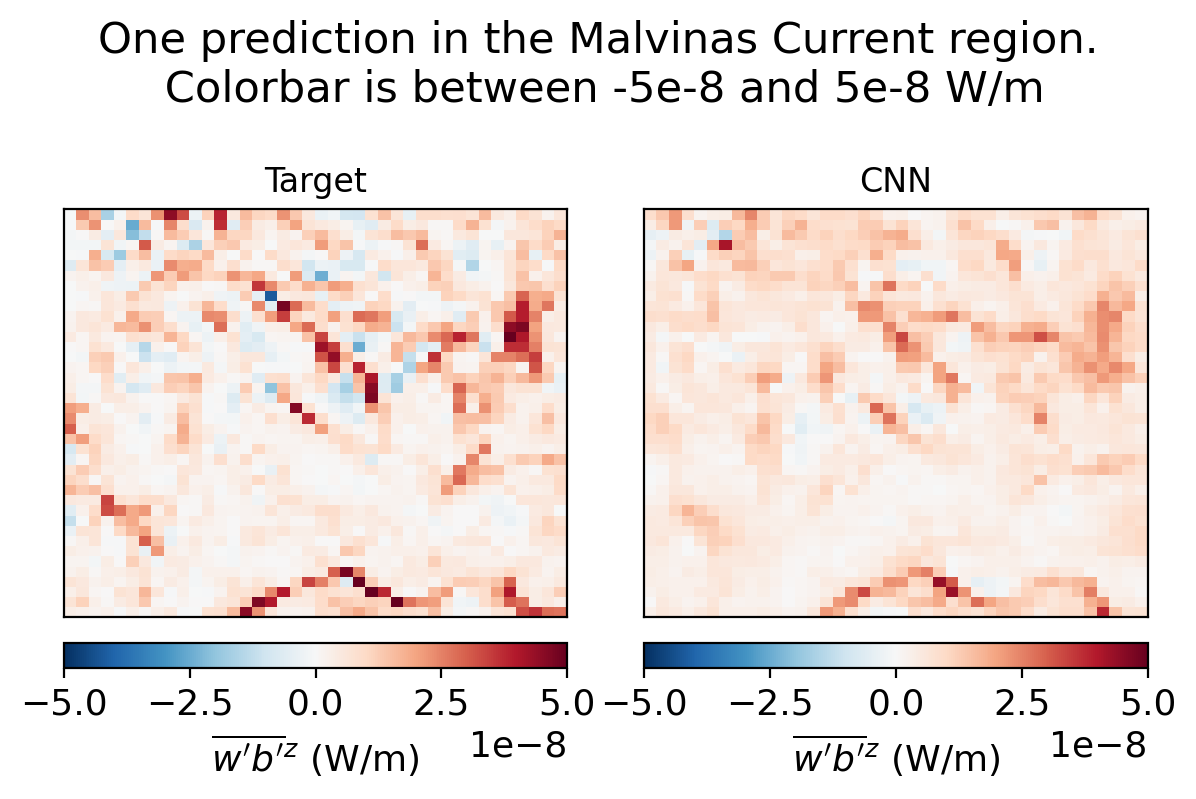

In [254]:
ind=83
clim = 5e-8

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(6,4))
target_map = y_test_og_xr[ind]
predicted_map = y_test_mse_pre.WB_sg_og[ind]

plt.subplot(1, 2, 1)
plt.pcolor(np.flip(target_map, axis=0),cmap='RdBu_r',vmin=-clim,vmax=clim)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(location='bottom',pad=0.05)
cb.set_label(r'$\overline{w^\prime b^\prime}^z$' + ' (W/m)')
plt.title('Target',fontsize=12)

plt.subplot(1, 2, 2)
plt.pcolor(np.flip(predicted_map, axis=0),cmap='RdBu_r',vmin=-clim,vmax=clim)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(location='bottom',pad=0.05)
cb.set_label(r'$\overline{w^\prime b^\prime}^z$' + ' (W/m)')
plt.title('CNN',fontsize=12)


loc_ind = int(target_map.location)
plt.suptitle('One prediction in the '+ label_list[loc_ind]+ ' region.\n Colorbar is between -5e-8 and 5e-8 W/m')
plt.tight_layout()

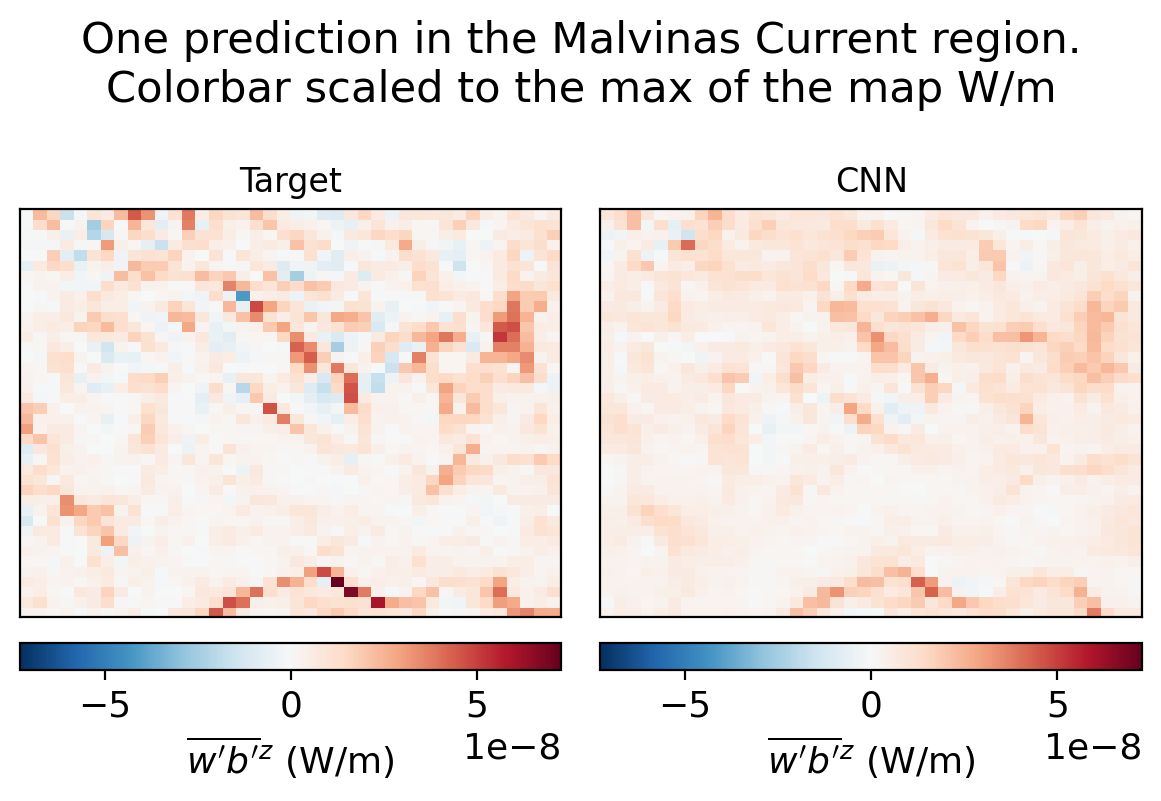

In [253]:
ind=83

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(6,4))
target_map = y_test_og_xr[ind]
predicted_map = y_test_mse_pre.WB_sg_og[ind]
clim = max([target_map.data.max(), abs(target_map.data.min()), predicted_map.data.max(), abs(predicted_map.data.min())])

plt.subplot(1, 2, 1)
plt.pcolor(np.flip(target_map, axis=0),cmap='RdBu_r',vmin=-clim,vmax=clim)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(location='bottom',pad=0.05)
cb.set_label(r'$\overline{w^\prime b^\prime}^z$' + ' (W/m)')
plt.title('Target',fontsize=12)

plt.subplot(1, 2, 2)
plt.pcolor(np.flip(predicted_map, axis=0),cmap='RdBu_r',vmin=-clim,vmax=clim)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(location='bottom',pad=0.05)
cb.set_label(r'$\overline{w^\prime b^\prime}^z$' + ' (W/m)')
plt.title('CNN',fontsize=12)


loc_ind = int(target_map.location)
plt.suptitle('One prediction in the '+ label_list[loc_ind]+ ' region.\nColorbar scaled to the max of the map W/m')
plt.tight_layout()

examples of good prediction: 18, 40, 47, 73, 80

examples of bad prediction: 
- low magnitude: 62
- dont get the negatives well: